In [1]:
# Default locations if parameter not passed
# benchmark_data_path = "tb-compare.pkl"
# benchmark_data_path = "tb-compare-coaraci.pkl"
benchmark_data_path = "pkl/tb-compare-sorgan-4164.pkl" # new imabalance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
import re
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

sns.set_theme()

# Experiment Metadata

In [3]:
# keep one experiment
# pick one experiment from the dataset
# get list of types and iterations
ran_types = df['type'].unique()
ran_iters = df['iter'].unique()
ran_kernels = df['kernel'].unique()

ran_outputs = []
if "output" in df.columns:
  ran_outputs = df['output'].unique()

# print the iters, kernels, types, the columns names
# print the columns names
rprint(f"Columns: {df.columns}")
rprint(benchmark_data['config'])
rprint(benchmark_data['metadata'])

Columns: Index(['name', 'ompc_tb_iter_num', 'ompc_init_iter', 'node_count', 'tb_path',
       'kernel', 'iter', 'full_output', 'hosts', 'ompc_resch_iter',
       'scheduler', 'type', 'image', 'time'],
      dtype='object')

SpinnerConfig(
    metadata=SpinnerMetadata(
        description='tb kernel compare benchmark',
        version='1.0',
        runs=5,
        timeout=600.0,
        retry=100,
        envvars=[]
    ),
    applications=SpinnerApplications(
        root={
            'tb-compare': SpinnerApplication(
                command=SpinnerCommand(
                    root='OMPCLUSTER_TASKBENCH_ITERATION_NUMBER={{ ompc_tb_iter_num}} 
OMPCLUSTER_INITIAL_SCHEDULE_POLICY=1 OMPCLUSTER_INITIAL_ITERATION_NUMBER={{ ompc_init_iter }} 
OMPCLUSTER_RESCHEDULING_INTERVAL={{ ompc_resch_iter }} OMPCLUSTER_SCHEDULER={{scheduler}} mpirun -np {{ node_count 
}} -ppn 1 -hosts "{{ hosts }}" apptainer exec --nv sifs/{{ image }} application/{{ tb_path }}/ompcluster/main 
-steps 32 -type {{type}}  -kernel {{kernel}}  -iter {{iter}}  -width 32\n'
                ),
                capture=[SpinnerCaptureAll(type='all', name='full_output')],
                plot=[]
            )
        }
    ),
    benchmarks=SpinnerBenchmarks(
        root={
            'tb-compare': SpinnerBenchmark(
                root={
                    'image': ['scheduler-main.sif', 'scheduler-main.sif', 'improv-144.sif'],
                    'tb_path': ['tb-main-loop', 'tb-main-loop', 'tb-tdg-no-loop'],
                    'scheduler': ['heft', 'roundrobin', 'heft'],
                    'zip': ['image', 'tb_path', 'scheduler'],
                    'ompc_tb_iter_num': [100],
                    'ompc_init_iter': [5],
                    'ompc_resch_iter': [1000],
                    'node_count': [2, 3, 4, 5, 6, 8, 8, 9, 10],
                    'kernel': ['load_imbalance'],
                    'type': ['fft'],
                    'iter': [1000, 1000000, 2000000]
                }
            )
        }
    )
)

{
    'hostname': 'sorgan-cpu1.cluster',
    'start_ts': Timestamp('2025-06-27 12:31:57.386848'),
    'start_env': {},
    'end_ts': Timestamp('2025-06-27 23:57:43.851978'),
    'end_env': {},
    'hosts': 
'sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4,sorgan-cpu5,sorgan-cpu6,sorgan-gpu1,sorgan-gpu2,sorgan-gpu3,sorgan
-gpu4'
}

In [4]:
bench_names = df["name"].unique()
print(f"Benchmarks found: {bench_names}")
run_metadata = benchmark_data["config"].applications
n_runs = benchmark_data["config"].metadata.runs

df_bar = df[df["name"] == 'tb-compare']


n_runs = benchmark_data["config"].metadata.runs
# print(f"Number of runs: {n_runs}")
# print(df_bar.columns)
# print(df_bar.head())
host_list = df_bar["hosts"].unique()

Benchmarks found: ['tb-compare']


In [5]:
dump_to_csv = False

if dump_to_csv:
    csv_path = os.path.join(os.path.dirname(benchmark_data_path), "tb-compare.csv")
    print(f"Dumping to {csv_path}")
    df_bar.to_csv(csv_path, index=False)

In [6]:
# tb_time field (seconds)
# get total time from the output
def extract_elapsed_time(text):
    matches = re.findall(r"Elapsed Time ([\d.eE+-]+) seconds", text)
    if matches:
        # gets last mach
        # float() already handles scientific notation
        return float(matches[-1])
    return float('nan')

def extract_total_sched_time(text):
    # Find all "Scheduling : <number>"
    matches = re.findall(r"Scheduling\s*:\s*(\d+)", text)
    if not matches:
        print("No scheduling time found in the text:")
        print(text)
        return None
    total_microseconds = sum(int(m) for m in matches)
    return total_microseconds / 1e6  # microseconds to seconds

def map_schedueler_name(image_name):
    if "improv" in image_name:
        return "Record Replay"
    return "Baseline"

def map_scheduler(row):
    if 'improv' in row['image'].lower():
        return 'Record Replay'
    if row['scheduler'] == 'roundrobin':
        return 'Baseline-RR'
    if row['scheduler'] == 'heft':
        return 'Baseline-HEFT'
    return np.nan  # or 'Baseline-Unknown'

df_bar['tb_time'] = df_bar['full_output'].apply(extract_elapsed_time)
df_bar['sched_time'] = df_bar['full_output'].apply(extract_total_sched_time)
# worker nodes is node_count - 1
df_bar['worker_nodes'] = df_bar['node_count'].apply(lambda x: int(x - 1) if x > 1 else None)
# df_bench['scheduler_name'] = df_bench['image'].apply(map_schedueler_name)
df_bar['scheduler_name'] = df_bar.apply(map_scheduler, axis=1)

# if there is no output column, add a dummy column
if 'output' not in df_bar.columns:
    df_bar['output'] = '0'

print(df_bar.columns)



No scheduling time found in the text:
[1751055390.173797] [sorgan-cpu1:4097216:0]        ib_verbs.h:87   UCX  ERROR ibv_exp_query_device(mlx5_0) returned 95: Operation not supported
[1751055390.185908] [sorgan-cpu2:3665775:0]        ib_verbs.h:87   UCX  ERROR ibv_exp_query_device(mlx5_0) returned 95: Operation not supported
Running Task Benchmark
  Configuration:
    Task Graph 1:
      Time Steps: 32
      Max Width: 32
      Dependence Type: fft
      Radix: 3
      Period: 0
      Fraction Connected: 0.250000
      Kernel:
        Type: load_imbalance
        Iterations: 1000
        Samples: 16
        Imbalance: 0.000000
      Output Bytes: 16
      Scratch Bytes: 0
Loop 0 : Elapsed time : 0.059788
Loop 1 : Elapsed time : 0.046381
Loop 2 : Elapsed time : 0.046629
Loop 3 : Elapsed time : 0.046940
Loop 4 : Elapsed time : 0.046858
Loop 5 : Elapsed time : 0.046243
Loop 6 : Elapsed time : 0.048691
Loop 7 : Elapsed time : 0.045733
Loop 8 : Elapsed time : 0.047507
Loop 9 : Elapsed time :

# Experiment 1

freeze, for now:
kernel: compute_bound
type: fft

freeze:
ompc_tb_iter_num: 100
ompc_init_iter: 5
ompc_resch_iter: 0

y axsis: tb_time
x axis: worker node count 

one line per iter

Processing: iter=1000, type=fft, kernel=load_imbalance


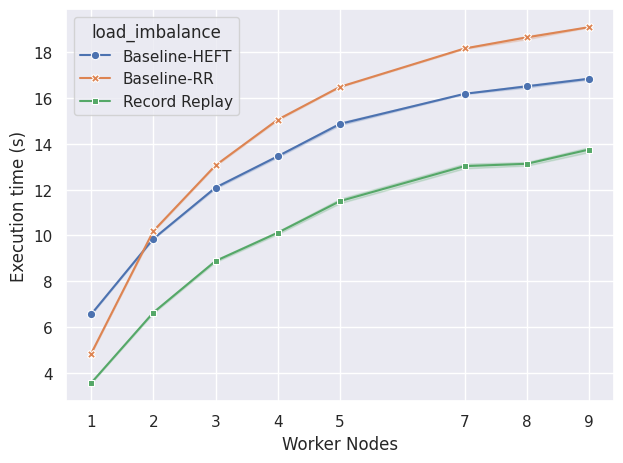

Processing: iter=1000000, type=fft, kernel=load_imbalance


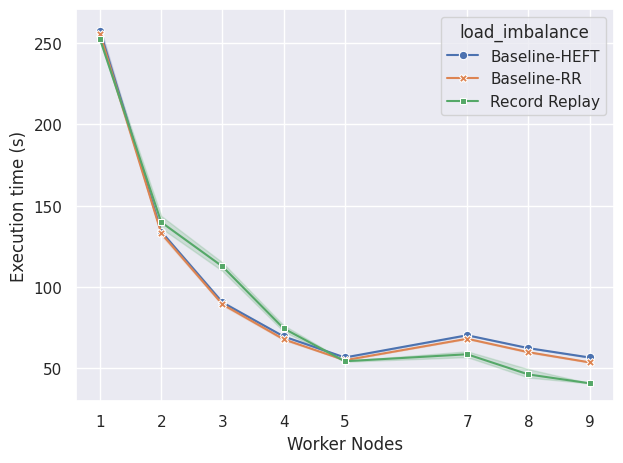

Processing: iter=2000000, type=fft, kernel=load_imbalance


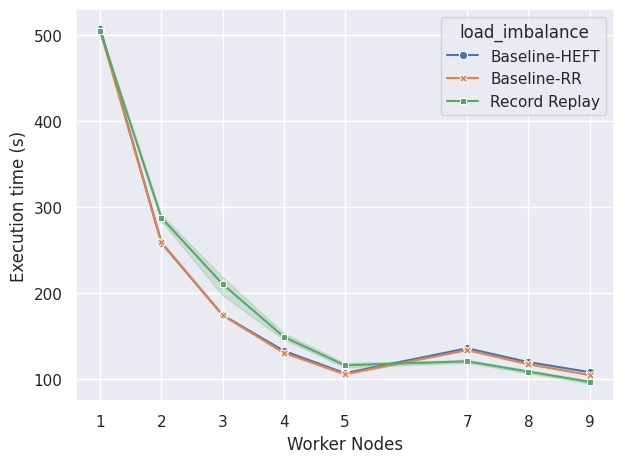

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop over every (iter, type, kernel) trio that actually exists
for (iter_val, type_val, kernel_val, output_val), g in df_bar.groupby(['iter', 'type', 'kernel', 'output']):
    print(f"Processing: iter={iter_val}, type={type_val}, kernel={kernel_val}")

    df_plot = (
        g[['tb_time', 'worker_nodes', 'scheduler_name']]
        .dropna(subset=['worker_nodes'])
    )

    plt.figure()
    sns.lineplot(
        data=df_plot,
        x='worker_nodes',
        y='tb_time',
        hue='scheduler_name',
        style='scheduler_name',
        markers=True,
        dashes=False,
        errorbar='ci',
    )

    plt.xlabel('Worker Nodes')
    plt.ylabel('Execution time (s)')
    plt.xticks(sorted(df_plot['worker_nodes'].unique()))
    plt.legend(title=kernel_val)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figs/tb-compare-{iter_val}-{type_val}-{kernel_val}-{output_val}-{host_list}.pdf")
    plt.show()


# Experiment 2

Show two stacked bars per worker node count.
First stacked bar is: 'Record Replay' scheduler total scheduling stacked over interpolation

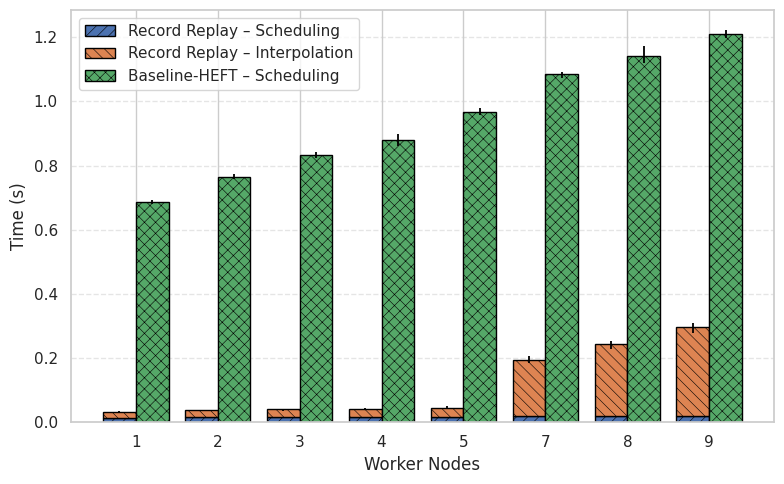

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
np.random.seed(0)

# ────────────────────────────────
# 1) helpers
# ────────────────────────────────
def extract_interpolation_time(txt: str) -> float:
    """Grab all 'Interpolation : <value>' hits (µs) and return sum in seconds."""
    hits = re.findall(r"Interpolation : ([\d.eE+-]+)", txt or "")
    return sum(map(float, hits)) / 1e6 if hits else 0.0


def ci_percentile_mean(data: np.ndarray, n_resamples: int = 2000,
                       ci: float = 95.0) -> tuple[float, float]:
    """Percentile bootstrap CI on the mean."""
    if len(data) < 2:
        m = data.mean() if len(data) else 0.0
        return m, m
    res = np.random.choice(data, size=(n_resamples, len(data)), replace=True)
    means = res.mean(axis=1)
    lo = np.percentile(means, (100 - ci) / 2)
    hi = np.percentile(means, 100 - (100 - ci) / 2)
    return lo, hi


# ────────────────────────────────
# 2) prepare dataframe
#    assumes you already have df_bar
# ────────────────────────────────
df = df_bar.copy()

df['interp_time'] = 0.0
rr_mask = df['scheduler_name'] == 'Record Replay'
df.loc[rr_mask, 'interp_time'] = df.loc[rr_mask, 'full_output']\
                                    .apply(extract_interpolation_time)

df['sched_time_remainder'] = df['sched_time'] - df['interp_time']
df = df.dropna(subset=['worker_nodes'])      # keep only valid rows

if len(ran_outputs) == 0:
    ran_outputs = ['0']  # default output if not present

ITER, TYPE, KERNEL, OUT_SIZE = ran_iters[0], ran_types[0], ran_kernels[0], ran_outputs[0]  # change as needed
df = df[(df['iter'] == ITER) & (df['type'] == TYPE) & (df['kernel'] == KERNEL) & (df['output'] == OUT_SIZE)]

# ────────────────────────────────
# 3) aggregate stats
# ────────────────────────────────
rows = []
for (nodes, sched), g in df.groupby(['worker_nodes', 'scheduler_name']):
    sched_vals  = g['sched_time_remainder'].to_numpy()
    interp_vals = g['interp_time'].to_numpy()
    tot_vals    = sched_vals + interp_vals

    # means
    mean_sched  = sched_vals.mean()
    mean_interp = interp_vals.mean()
    mean_total  = tot_vals.mean()

    # CI on TOTAL only
    lo_tot, hi_tot = ci_percentile_mean(tot_vals)

    rows.append({
        'worker_nodes':   nodes,
        'scheduler_name': sched,
        'sched_mean':     mean_sched,
        'interp_mean':    mean_interp,
        'total_mean':     mean_total,
        'total_lo':       lo_tot,
        'total_hi':       hi_tot,
    })

stats = pd.DataFrame(rows)

# ────────────────────────────────
# 4) pivot for plotting
# ────────────────────────────────
plt.rcParams['hatch.linewidth'] = 0.4
order = ['Record Replay', 'Baseline-HEFT']     # customise to taste
n_sched = len(order)
width   = 0.8 / n_sched
colors  = sns.color_palette('deep', n_sched * 2)
hatches = ['///', '\\\\\\', 'xxx','-', '/', 'x', '+', 'o', '.'] * n_sched

nodes = sorted(stats['worker_nodes'].unique())
x = np.arange(len(nodes))

def pivot(col):
    return (
        stats
        .pivot(index='worker_nodes', columns='scheduler_name', values=col)
        .loc[nodes, order]
        .to_numpy()
    )

sched_mean   = pivot('sched_mean')
interp_mean  = pivot('interp_mean')
total_mean   = pivot('total_mean')
total_lo     = pivot('total_lo')
total_hi     = pivot('total_hi')

# ────────────────────────────────
# 5) plot
# ────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))

for i, name in enumerate(order):
    pos = x + (i - (n_sched - 1)/2) * width

    # scheduling block
    ax.bar(pos, sched_mean[:, i], width,
           color=colors[2*i], label=f'{name} – Scheduling', zorder=1, hatch=hatches[2*i], edgecolor='black')

    # interpolation block stacked
    if name != 'Baseline-HEFT':
      ax.bar(pos, interp_mean[:, i], width,
            bottom=sched_mean[:, i],
            color=colors[2*i+1], label=f'{name} – Interpolation', zorder=1,
            hatch=hatches[2*i+1], edgecolor='black')

    # vertical CI line on the total height
    ax.vlines(pos,
              total_lo[:, i],
              total_hi[:, i],
              colors='black',
              linewidth=1.3,
              zorder=3)

# cosmetics
ax.set_xticks(x)
ax.set_xticklabels(nodes)
ax.set_xlabel('Worker Nodes')
ax.set_ylabel('Time (s)')
#ax.set_title(f'FFT dependency – iters={ITER}, type={TYPE.upper()}')
# ax.legend(title=f"{KERNEL},{ITER},{TYPE.upper()},{OUT_SIZE}")
ax.legend(title=f"", loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"figs/tb-compare-coaraci2-{ITER}-{TYPE}-{KERNEL}-{OUT_SIZE}-{host_list}.pdf")
plt.show()
